# Radar Imaging based on Delay-and-Sum Beamforming <img style="float: right; width: 160px" src="../images/logo-2pi-labs.png">
--- 
<img style="float: right; height: 50px; padding-right: 15px" src="../images/cc-by-nc-sa.eu.png">

**Author**: Jan Barowski, 2pi-Labs GmbH \
**License**: Creative Commons [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) 

<img src="../images/img-examples.jpg" width="100%">

## Literature

[1] Kissinger, D. (2012). Radar Fundamentals. In: Millimeter-Wave Receiver Concepts for 77 GHz Automotive Radar in Silicon-Germanium Technology. SpringerBriefs in Electrical and Computer Engineering. Springer, Boston, MA.

[2] Kueppers, S., Jaeschke, T., Pohl, N., & Barowski, J. (2021). Versatile 126–182 GHz UWB D-Band FMCW Radar for Industrial and Scientific Applications. IEEE Sensors Letters, 6(1), 1-4.

[3] Schorlemer, J., Schulz, C., Pohl, N., Rolfes, I., & Barowski, J. (2021). Compensation of sensor movements in short-range FMCW synthetic aperture radar algorithms. IEEE Transactions on Microwave Theory and Techniques, 69(11), 5145-5159.

## Delay-and-Sum Signal Model
As seen in previous notebooks, the receive signal of the FMCW radar sensor is the mixing product of transmit and receive ramp [1]. The trick in FMCW now is the quasi-homodyne downconversion in the RX mixer that multiplies the RX and the TX signal. By downconverting the signal, we calculate the difference of the cosine-arguments and remove all RF components. This gives the intermediate- (IF-) or beat-signal $s(t)$:

\begin{equation}
s(t) = \overline{x(t)y(t)} = AB\cdot\mathrm{cos}(\omega_0 \tau + \frac{\Omega\tau t }{T} - \frac{\tau^2\Omega}{2T}) = AB\cdot\mathrm{cos}( (\omega_0 + \frac{\Omega t }{T})\tau - \frac{\tau^2\Omega}{2T}) \tag{1}
\end{equation}

The second part of the argument above $\frac{\tau^2\Omega}{2T}$ is usually neglected since $\tau^2 << T$. Problems may arise in ultrawideband sweep or very short sweep times, i.e. extremely large frequency gradients. The simplified IF-signal therefore is: 

\begin{equation}
s(t) =  AB\cdot\mathrm{cos}( (\omega_0 + \frac{\Omega t }{T})\tau) \tag{2}
\end{equation}

We can also rewrite this to look at the beat signal frequency more cleary:

\begin{equation}
s(t) =  AB\cdot\mathrm{cos}( \frac{\Omega \tau }{T} t + \omega_0 \tau ) = AB\cdot\mathrm{cos}( \omega_{IF} t + \phi_0 ) \tag{3}
\end{equation}

Therefore, the beat signal frequency is related to the ramp gradient $\frac{\Omega}{T}$ and the roundtrip-time-delay $\tau = \frac{2R}{c_0}$ of the target, whereas the receive phase of a target depends on the start frequency of the FMCW sweep
\begin{equation}
\phi_0 = \omega_0 \tau = \omega_0 \frac{2R}{c_0} = 2 k_0 R \tag{4}
\end{equation}

when using the wavenumber $k=\frac{\omega}{c}$.

The basic idea behind the *Delay-and-Sum beamformer* is to coherently superimpose all radar echos without a priori knowledge on the direction of incidents, by extrapolating the range-/echo-profile onto circles. Therefore, the complex reflection magnitude of a target at distance $R_0$ is extrapolated onto a circle of this radius. Additionally, the offset-phase $\phi_0$, which depends on the target distance has to be compensated, since the same target, seen from varying distances changes its phase.

## Algorithm summary

The Delay-and-Sum algorithm now works in 4 steps:

1. Create a discretized image domain in x-,y-,z-dimension with given regions (x-min,x-max, etc.) and given number of datapoints (Nx,Ny,Nz) and initilaize and empty complex image grid $I$

2. For each measurement-/antenna-position:
    
    2.1.  calculate the current distance of all pixels to this point

    \begin{equation}
    R = \sqrt{ (X_{pix} - X_{ant})^2 + (Y_{pix} - Y_{ant})^2 + (Z_{pix} - Z_{ant})^2 } \tag{5}
    \end{equation}

    2.2.  get the complex magnitude from the radar echo at this distance by interpolation

    \begin{equation}
    E = \mathrm{1DInterpolation}(R, rangeaxis, complexecho)   \tag{6}
    \end{equation}

    2.3.  calculate and compensate for the phase shift at this distance

    \begin{equation} 
    \phi_0 = 2 k_0 R \tag{7}
    \end{equation}
    
    \begin{equation}
    E_{comp} = E * exp(-1j \phi_0) \tag{8}
    \end{equation}

3. Sum up all phase-compensated data-points

\begin{equation}
I = \sum_n E_{comp,n} \tag{9}
\end{equation}

Typical sources of error in this loop are the sign of the phase compensation term (7,8), which changes depending on whether you employ a FFT or IFFT in radar echo calulation. The sign of the phase compensation does also change depending on the FMCW sweep direction (Up- or Down-chirp). Furthermore, one has to take care with the distance calculation, whether the round-trip or single-trip distance is used (factor of 2 in phase compensation). 







In the following the processing of a 1D scan (x-direction) will be done. A 2πSENSE X1000 FMCW radar sensor [2] sensor is mounted on a moving stage [3] and doing a scan above a corner-reflector / trihedral reflector. 300 measurement positions are recorded over a distance of 0.3m line. The processing is done in three steps:
1. Import data and inspect in frequency-/IF-signal-domain
2. Range compress data to obtain radar echo profiles
3. Cross-Range compress data to achieve azimuth resolution and create an image

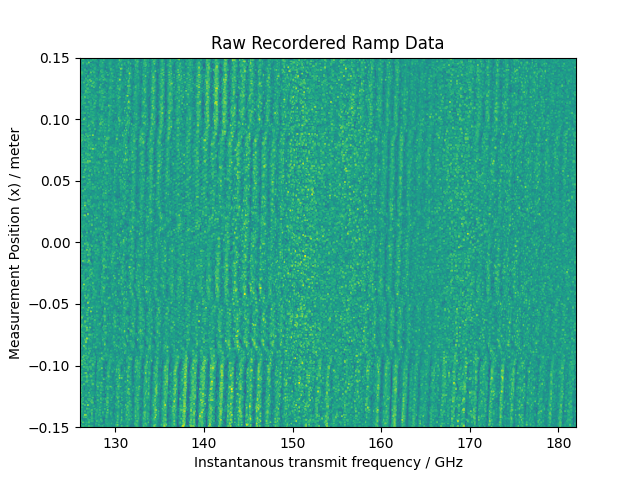

In [1]:
%matplotlib widget
from twopilabs.sense.x1000 import SenseX1000
import numpy as np
import h5py
import scipy.io as io
import matplotlib.pyplot as plt
from scipy.signal import windows as windows
from scipy.constants import c as c0

# open hdf5 file containing recordered data
filename = "../data/img-data-trihedral.hdf5"
file = h5py.File(filename,'r')

# all datasets of scan
datasets = list( file["scan"].keys() )

# get metadata from first dataset
frequency = SenseX1000.AcqData.from_hdf5(file["scan"], name=datasets[0]).header.freq_axis
F = len( frequency )
N = len( datasets )

# initialize empty variables 
ramps = np.zeros((N, F))
position = np.zeros((N, 3))

# fill variables with sweep data
for n in range(N):        
    # IF-signals
    ramps[n,:] = file["scan"][datasets[n]]["acquisition_data"][0,0,:] 
    # current measurement position (stored position data is in millimeter instead of meter)
    position[n,:] = file["scan"][datasets[n]]["position"][:] / 1e3 

# centralize image to 0
position = position - np.mean(position, axis=0)

# remove antenna reflections by subtracting an average off all measurement 
ramps = ramps - np.mean(ramps,axis=0)

# show IF-Domain / Frequency-Domain Data
fig = plt.figure()
ax = fig.add_subplot()
ax.contourf(frequency[::10]/1e9, position[:,0], ramps[:,::10],100)
ax.set_xlabel("Instantanous transmit frequency / GHz")
ax.set_ylabel("Measurement Position (x) / meter")
ax.set_title("Raw Recordered Ramp Data");

## Performing Range-Compression (Calulate Echos based on FFT)

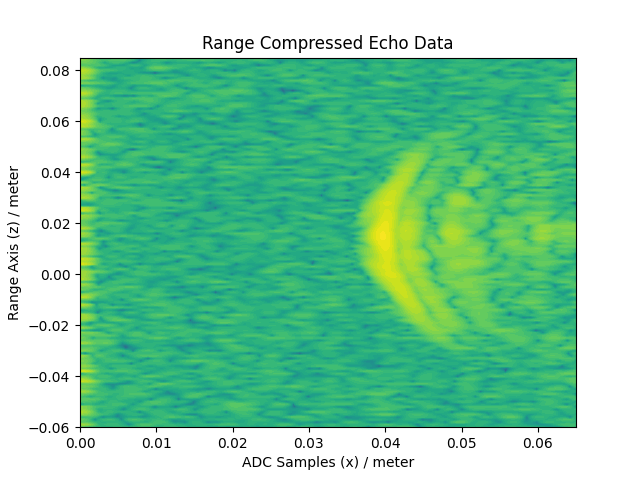

In [2]:
# Range Compression settings
NFFT = 8192*4 # number of FFT points
rangeGate = (0, 0.065) # maximum range of interest

# calculate radar echos by IFFT
echos = np.fft.ifft(ramps*windows.hann(F),n=NFFT,axis=1)

# unambigous range of time delay axis 
taumax = 1/np.abs(frequency[1]-frequency[0])

# scaled unambigous range of range-axis
Rmax = c0 / 2 * taumax

# calculate range axis of radar echo
range_axis = np.arange(NFFT)/NFFT * Rmax / 2

# crop radar echo to region of interest to reduce data for plotting
v = range_axis < 0.065
range_axis, echos = range_axis[v], echos[:, v]

# show IF-Domain / Frequency-Domain Data
fig = plt.figure()
ax = fig.add_subplot()
ax.contourf(range_axis,position[:,0], 20*np.log10(np.abs(echos)), 50)
ax.set_xlim(0, 0.065)
ax.set_ylim(-0.06, 0.085)
ax.set_xlabel("ADC Samples (x) / meter")
ax.set_ylabel("Range Axis (z) / meter" )
ax.set_title("Range Compressed Echo Data");


## Delay-and-Sum Processing

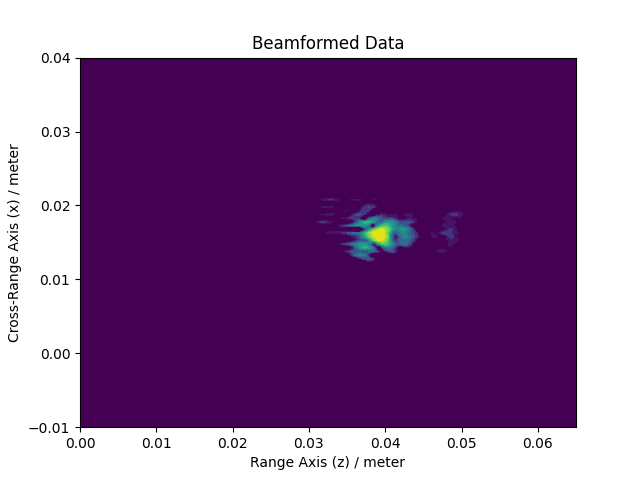

In [3]:
# Azimuth Compression
# image domain extents in x- and z-dimension, y is constantly 0
Nx = 600
Ny = 1
Nz = 600
x_im = np.linspace( min(position[:,0]) , max(position[:,0]) , Nx)
y_im = np.linspace( 0,  0   , Ny)
z_im = np.linspace( 0 , 0.1 , Nz)

# create 3D arrays from 1D axis vectors
(X,Y,Z) = np.meshgrid(x_im,y_im,z_im)

# initialize complex image
I = np.zeros(X.shape, dtype=complex)

# wavennumber at start frequency
k0 = 2 * np.pi * frequency[0] / c0

# for each measurement
for n in range(N):
    # distance from all pixels to this antenna position eq. (5)
    distance = np.sqrt( (X-position[n,0])**2 + (Y-position[n,1])**2 + (Z-position[n,2])**2  ) 

    # phase compensation term eqs. 6 and 7
    phase = np.exp(-1j* 2 * k0 * distance)
    
    # interpolation eq. 8
    E = np.interp(distance, range_axis, echos[n,:])

    # coherent sum eq. 9
    I = I + E * phase

# normalize image to max.
I = I / np.max(np.abs(I.flatten()))

# show Image
plt.figure()
plt.contourf(z_im,x_im,20*np.log10(np.abs(I[0,:,:])),50)
plt.xlabel("Range Axis (z) / meter")
plt.ylabel("Cross-Range Axis (x) / meter")
plt.xlim(0, 0.065)
plt.ylim(-0.01, 0.04)
plt.title("Beamformed Data")
plt.clim(-15,0)

### Done!